In [6]:
import sys
import gdal
import h5py
import numpy as np
from math import floor
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(diff_dsm_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [8]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [9]:
def check_extents_of_data(data, ext_lim):
    for di, d in enumerate(data[1:]):
        if data[0][1]['ext_dict'][ext_lim] != d[1]['ext_dict'][ext_lim]:
            sys.exit('Ext_dict %s from datasets [%d] and [0] do not match (%d, %d)' 
                     % (ext_lim, di + 1, d[1]['ext_dict'][ext_lim], data[0][1]['ext_dict'][ext_lim]))

In [10]:
data_dir = '../RSDI-2017/DI17-California/PRIN'
files = ['2016_PRIN_1_607000_3696000_DSM.tif', 
         '2016_PRIN_2_607000_3696000_DSM.tif',
        '2016_PRIN_1_607000_3696000_DTM.tif',
         '2016_PRIN_2_607000_3696000_DTM.tif',
         '2016_PRIN_1_607000_3696000_pit_free_CHM.tif']

In [11]:
file_names = [os.path.join(data_dir, f) for f in files]

In [12]:
data = [raster2array(f) for f in file_names]

In [13]:
[[dsm_array1, meta_sm1], 
 [dsm_array2, meta_sm2], 
 [dtm_array1, meta_tm1], 
 [dtm_array2, meta_tm2],
 [chm_array, meta_chm]] = data 

In [14]:
image_extent = (meta_sm1['ext_dict']['xMin'], 
                 meta_sm1['ext_dict']['xMax'],
                 meta_sm1['ext_dict']['yMin'], 
                 meta_sm1['ext_dict']['yMax'])

In [15]:
for ext_lim in ['xMin', 'xMax', 'yMin', 'yMax']:
    check_extents_of_data(data, ext_lim)

In [16]:
diff_dsm_array = np.subtract(dsm_array1,dsm_array2)
diff_dtm_array = np.subtract(dtm_array1,dtm_array2) 

In [17]:
diff_dsm_array_mean = np.mean(diff_dsm_array)
diff_dsm_array_std = np.std(diff_dsm_array)
print('Mean difference in DSMs: ',round(diff_dsm_array_mean,3),' (m)')
print('Standard deviations of difference in DSMs: ',round(diff_dsm_array_std,3),' (m)')

Mean difference in DSMs:  0.019  (m)
Standard deviations of difference in DSMs:  0.743  (m)


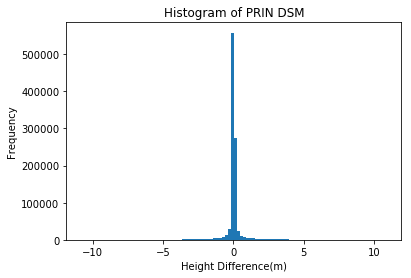

In [18]:
plt.figure(1)
plt.hist(diff_dsm_array.flatten(),100)
plt.title('Histogram of PRIN DSM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

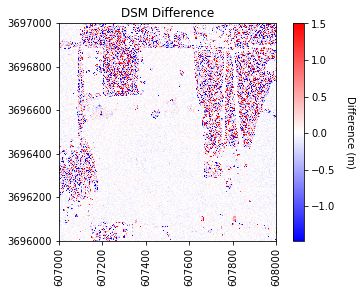

In [19]:
plt.figure(3)
plot_band_array(diff_dsm_array,image_extent,
                'DSM Difference','Difference (m)','bwr',
                [diff_dsm_array_mean-2*diff_dsm_array_std, 
                 diff_dsm_array_mean+2*diff_dsm_array_std])

Mean difference in DTMs:  0.014  (m)
Standard deviations of difference in DTMs:  0.102  (m)


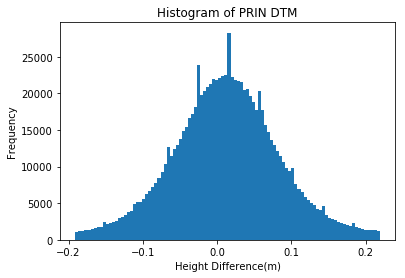

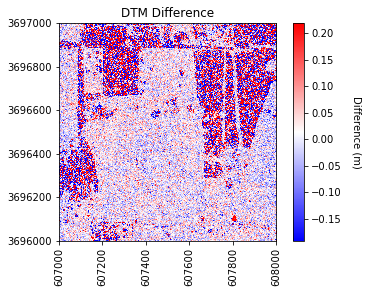

In [20]:
diff_dtm_array_mean = np.nanmean(diff_dtm_array)
diff_dtm_array_std = np.nanstd(diff_dtm_array)
print('Mean difference in DTMs: ',round(diff_dtm_array_mean,3),' (m)')
print('Standard deviations of difference in DTMs: ',round(diff_dtm_array_std,3),' (m)')          

plt.figure(4)
plt.hist(diff_dtm_array.flatten()[~np.isnan(diff_dtm_array.flatten())],100,range=[diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])
plt.title('Histogram of PRIN DTM')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

plt.figure(5)
plot_band_array(diff_dtm_array,image_extent,'DTM Difference','Difference (m)','bwr',[diff_dtm_array_mean-2*diff_dtm_array_std, diff_dtm_array_mean+2*diff_dtm_array_std])

6.34398923227 1.81491673033


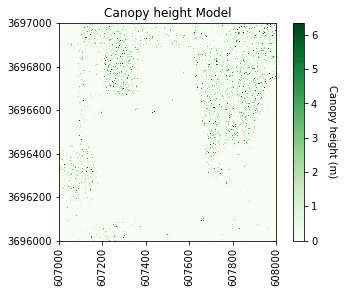

In [21]:
chm_array_mean = np.nanmean(chm_array[chm_array!=0])
chm_array_std = np.nanstd(chm_array[chm_array!=0])
plt.figure(6)
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, chm_array_mean])
plt.savefig('PRIN_CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)
print(chm_array_mean, chm_array_std)

Mean difference in DSMs on veg points:  0.064  (m)
Standard deviations of difference in DSMs on veg points:  1.381  (m)


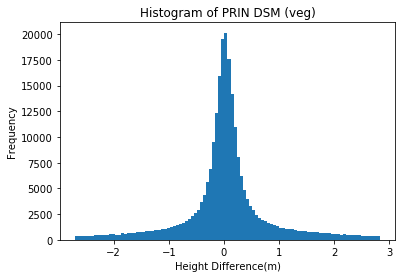

In [22]:
diff_dsm_array_veg_mean = np.nanmean(diff_dsm_array[chm_array!=0.0])
diff_dsm_array_veg_std = np.nanstd(diff_dsm_array[chm_array!=0.0])
plt.figure(7)
print('Mean difference in DSMs on veg points: ',round(diff_dsm_array_veg_mean,3),' (m)')
print('Standard deviations of difference in DSMs on veg points: ',round(diff_dsm_array_veg_std,3),' (m)')

plt.figure(8)
diff_dsm_array_nodata_removed = diff_dsm_array[~np.isnan(diff_dsm_array)]
chm_dsm_nodata_removed = chm_array[~np.isnan(diff_dsm_array)]
plt.hist(diff_dsm_array_nodata_removed[chm_dsm_nodata_removed!=0.0],100,range=[diff_dsm_array_veg_mean-2*diff_dsm_array_veg_std, diff_dsm_array_veg_mean+2*diff_dsm_array_veg_std])
plt.title('Histogram of PRIN DSM (veg)')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

Mean difference in DTMs on veg points:  0.023  (m)
Standard deviations of difference in DTMs on veg points:  0.163  (m)


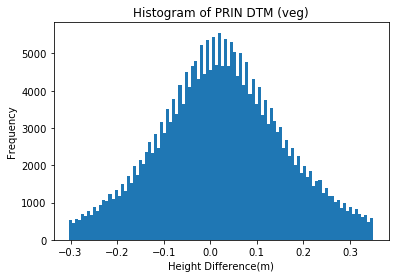

In [23]:
diff_dtm_array_veg_mean = np.nanmean(diff_dtm_array[chm_array!=0.0])
diff_dtm_array_veg_std = np.nanstd(diff_dtm_array[chm_array!=0.0])
plt.figure(9)
print('Mean difference in DTMs on veg points: ',round(diff_dtm_array_veg_mean,3),' (m)')
print('Standard deviations of difference in DTMs on veg points: ',round(diff_dtm_array_veg_std,3),' (m)')

plt.figure(10)
diff_dtm_array_nodata_removed = diff_dtm_array[~np.isnan(diff_dtm_array)] 
chm_dtm_nodata_removed = chm_array[~np.isnan(diff_dtm_array)]
plt.hist((diff_dtm_array_nodata_removed[chm_dtm_nodata_removed!=0.0]),100,range=[diff_dtm_array_veg_mean-2*diff_dtm_array_veg_std, diff_dtm_array_veg_mean+2*diff_dtm_array_veg_std])
plt.title('Histogram of PRIN DTM (veg)')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

Mean difference in DTMs on ground points:  0.011  (m)
Standard deviations of difference in DTMs on ground points:  0.068  (m)


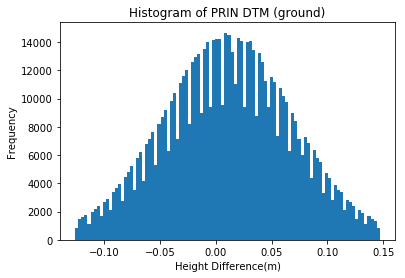

In [24]:
diff_dtm_array_ground_mean = np.nanmean(diff_dtm_array[chm_array==0.0])
diff_dtm_array_ground_std = np.nanstd(diff_dtm_array[chm_array==0.0])
print('Mean difference in DTMs on ground points: ',round(diff_dtm_array_ground_mean,3),' (m)')
print('Standard deviations of difference in DTMs on ground points: ',round(diff_dtm_array_ground_std,3),' (m)')

plt.figure(11)
plt.hist((diff_dtm_array_nodata_removed[chm_dtm_nodata_removed==0.0]),100,range=[diff_dtm_array_ground_mean-2*diff_dtm_array_ground_std, diff_dtm_array_ground_mean+2*diff_dtm_array_ground_std])
plt.title('Histogram of PRIN DTM (ground)')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')

In [25]:
from scipy import stats
chm_f = chm_array[chm_array!=0].flatten()
diff_dtm_f = diff_dtm_array[chm_array!=0].flatten()
diff_dsm_f = diff_dsm_array[chm_array!=0].flatten()

diff_dtm_fabs = np.abs(diff_dtm_f)
diff_dsm_fabs = np.abs(diff_dsm_f)

diff_dtm_fabs_normed = np.abs(diff_dtm_f / chm_f)
diff_dsm_fabs_normed = np.abs(diff_dsm_f / chm_f)

In [26]:
def plot_diff_scatter(x, y, xlabel, ylabels):
    fig = plt.figure(figsize=(10, 5))
    for ii, [yi, li] in enumerate(zip(y, ylabels)):
        ax = fig.add_subplot(1, 2, 1+ii)
        r = stats.spearmanr(x, yi)
        ax.scatter(x, yi, alpha=0.05, label= 'corr: %-5.2f (%-5.2f)'%(r[0], r[1]))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(li)
        plt.legend()
    plt.show

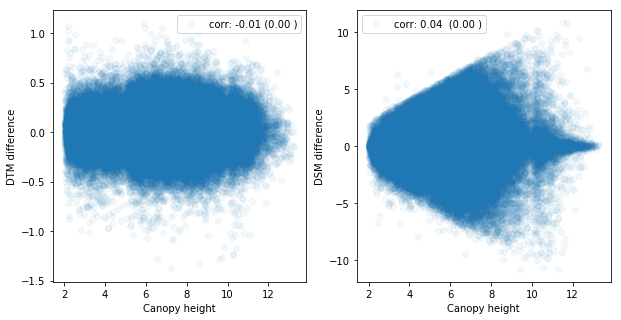

In [27]:
plot_diff_scatter(chm_f, [diff_dtm_f, diff_dsm_f], 'Canopy height', ['DTM difference', 'DSM difference'])

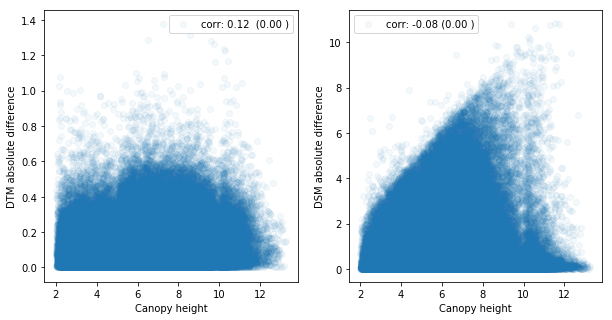

In [28]:
plot_diff_scatter(chm_f, [diff_dtm_fabs, diff_dsm_fabs], 'Canopy height', ['DTM absolute difference', 'DSM absolute difference'])

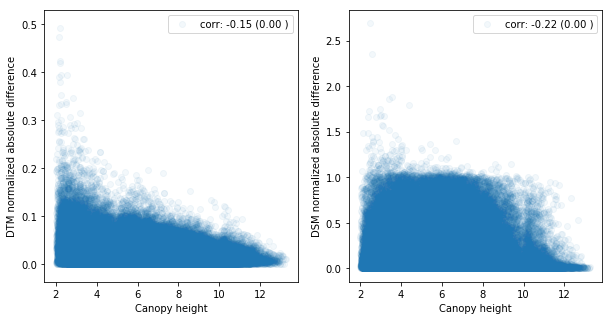

In [29]:
plot_diff_scatter(chm_f, [diff_dtm_fabs_normed, diff_dsm_fabs_normed], 'Canopy height', 
                  ['DTM normalized absolute difference', 'DSM normalized absolute difference'])